# Using pytorch to solve an inverse problem in glaciology - a maximally minimal example

As we have seen in the previous sections, the capacity to differentiate scalar functions representing the deviation of a model prediction from a desired outcome is perhaps *the* fundamental operation for both Machine Learning as its currently understood and classical inverse methods.  In both cases, this functionality is facilitated via reverse-mode automatic differentiation, which is closely related to the *adjoint method*.  Here we will show how we can use library pytorch, which at its core is a library for logging the computational graph associated with a given computation and providing atomic vector-Jacobian products for a large variety of mathematical operations, to solve a very basic inverse problem in glaciology, namely the recovery of the ice hardness parameter $A$ from an observation of surface velocity.  Of course, there are better ways to do this - we could presumably solve for $A$ directly, but this method provides am illustrative mechanism for using pytorch in conjunction with a physical model. 

First, let's look at our data.  In particular, we will imagine the situation in which we went out to some place in the middle of the Greenland ice sheet and measured the position of a stake 1 year apart, giving us a speed, which we will call $u_{obs}$.  Let's say we measured a velocity of $116$m a$^{-1}$.  Next, let us define the shallow ice approximation.  
$$
\frac{\partial}{\partial z} \eta \frac{\partial u}{\partial z} = \rho g \frac{\partial S}{\partial x},
$$
where $\rho=917$ km m$^{-3}$ is the ice density, $g=9.81$m s$^{-2}$ is the gravitational acceleration, $z$ is the vertical coordinate, $x$ is the coordinate in the along-flow direction, $\frac{\partial S}{\partial x}=-0.1$ is the surface slope in the along-flow direction, and $u$ is the velocity in the along flow direction.  Note we assume that the various constants, including slope, have been measured here.  $\eta$ is the viscosity, and for the SIA is defined as 
$$
\eta = \frac{A^\frac{-1}{n}}{2} \left[\frac{1}{4}\frac{\partial u}{\partial z}^2 + \epsilon\right]^{\frac{1-n}{2n}},
$$
with $\epsilon$ a small regularization coefficient.  The SIA also requires boundary conditions at the surface and base: at the surface we assume the no-stress condition 
$$
\eta \frac{\partial u}{\partial z} = 0 
$$
and at the bed the no-slip condition
$$
u(z=B) = 0.
$$
Here we also assume that we know the bed elevation $B$, surface elevation $S$, and thus thickness $H=S-B$.  The SIA is unusual in that it has an analytical solution for this choice of boundary conditions:
$$
u(z) = -\frac{A}{2} (\rho g)^n \left|\frac{\partial S}{\partial x}\right|^{n-1} \bigg(H^{n+1} - (S-z)^{n+1}\bigg) \frac{\partial S}{\partial x},
$$
and it is straightforward to build a model that evaluates this function in torch.  

In [1]:
import torch

def u_sia(z,A,H,S,dSdx,rho,g,n):
    return -0.5*A*(rho*g)**n*abs(dSdx)**(n-1)*(H**(n+1) - (S-z)**(n+1))*dSdx   

A = 1e-16
dSdx = -0.1
H = 200
rho = 917
g = 9.81
n = 3.0

S = 500
z = torch.linspace(S-H,S,101)

u_pred = u_sia(z,A,H,S,dSdx,rho,g,n)

Note that we made a guess for $A$ which gives us a velocity.  But again, what if we would like to infer it from data?  Let's plot our predicted velocity against our observation and see how our guess is.

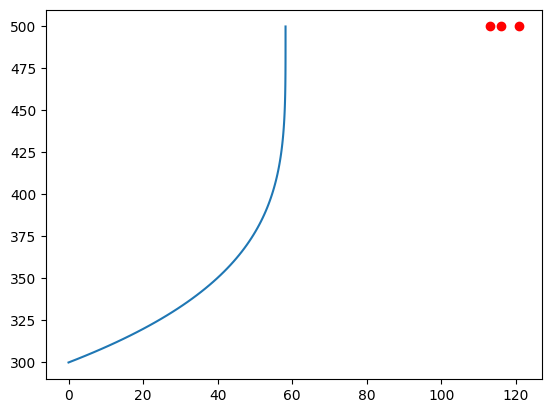

In [2]:
import matplotlib.pyplot as plt
u_obs = torch.tensor([116,121,113])

plt.plot(u_pred,z)
plt.plot(u_obs, S*torch.ones_like(u_obs),'ro')

We have significantly underestimated the velocity in this case.  To rectify the situation, let us pose the problem of finding $A$ as a minimization problem
$$
A^* = \mathrm{argmin}_A (u_S(A) - u_{obs})^2,
$$
which is to say that we'd like to find the value of $A$ that minimizes the difference between the SIA-predicted surface velocity and the observation.  We could solve this with gradient descent - but first we need to know the gradients.  Pytorch makes this very easy.  

Before we get to solving it, it's helpful to inject some domain knowledge into the problem to head off a future issue.  Note that only positive values of $A$ are physically meaningful - there is no such thing as a negative viscosity.  However, gradient descent is an algorithm for *unconstrained* optimization, which is to say that it will quite happily push $A$ to be negative.  To avoid this problem (which is extremely common in glaciology), we will just do a simple reparameterization
$$
A = \mathrm{e}^\alpha,
$$
and infer $\alpha$ instead.  The exponential function is monotonic, so if we know $\alpha$ we know $A$ and vice versa.  

Pytorch is a reverse mode AD tool, which means that it computes the gradients of scalar functions with respect to any number of "upstream" variables.  In this case, we only have one that we're interested in computing the gradients of the squared error with respect to.  We can signal this to pytorch with the requires_grad flag

In [3]:
alpha = torch.tensor(-37.,requires_grad=True)

Now, let's evaluate the velocity with this parameter value.

In [4]:
A = torch.exp(alpha)
u_pred = u_sia(z,A,H,S,dSdx,rho,g,n)
print(u_pred)

tensor([ 0.0000,  1.9582,  3.8579,  5.7003,  7.4867,  9.2180, 10.8956, 12.5205,
        14.0937, 15.6165, 17.0900, 18.5151, 19.8930, 21.2247, 22.5112, 23.7537,
        24.9531, 26.1104, 27.2266, 28.3027, 29.3397, 30.3385, 31.3001, 32.2254,
        33.1154, 33.9709, 34.7929, 35.5822, 36.3397, 37.0664, 37.7629, 38.4303,
        39.0692, 39.6806, 40.2652, 40.8238, 41.3572, 41.8662, 42.3516, 42.8140,
        43.2542, 43.6729, 44.0709, 44.4488, 44.8074, 45.1472, 45.4690, 45.7735,
        46.0611, 46.3327, 46.5887, 46.8298, 47.0566, 47.2697, 47.4695, 47.6568,
        47.8320, 47.9956, 48.1483, 48.2904, 48.4224, 48.5449, 48.6584, 48.7632,
        48.8599, 48.9489, 49.0305, 49.1053, 49.1735, 49.2357, 49.2921, 49.3431,
        49.3891, 49.4305, 49.4675, 49.5005, 49.5297, 49.5555, 49.5782, 49.5980,
        49.6151, 49.6298, 49.6424, 49.6531, 49.6620, 49.6694, 49.6755, 49.6804,
        49.6843, 49.6873, 49.6896, 49.6913, 49.6926, 49.6934, 49.6940, 49.6943,
        49.6945, 49.6946, 49.6946, 49.69

Note that this is looks similar to before, but now there is a tag at the end that says grad_fn.  This is telling us what operation produced this array (torch also keeps track of the other function arguments).  Similarly if we look at $A$

In [5]:
A

tensor(8.5330e-17, grad_fn=<ExpBackward0>)

we see that it was generated via the exponential function (from $\alpha$).  Now let's compute a misfit

In [6]:
def misfit(u_pred,u_obs):
    return ((u_pred[-1] - u_obs)**2).mean()

L = misfit(u_pred,u_obs) 
print(L)

tensor(4496.1470, grad_fn=<MeanBackward0>)


This is just a scalar function (note the indexing into the array u_pred).  To compute the derivative of it with respect to every desired input function, we can call

In [7]:
L.backward()

/home/brinkerhoff/miniconda3/envs/working/lib/python3.11/site-packages/torch/autograd/__init__.py:251: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


To see what this function call did, we can inspect a new array associated with $\alpha$ called grad, which stores the values $\frac{\partial L}{\partial \alpha}$.  

In [8]:
print(alpha.grad)

tensor(-6656.2998)


We can verify that this is correct using the finite difference method:

In [9]:
delta = 1e-3
alpha_perturbed = (alpha + delta).detach()
u_pred_perturbed = u_sia(z,torch.exp(alpha_perturbed),H,S,dSdx,rho,g,n)
L_perturbed = misfit(u_pred_perturbed,u_obs)
print((L_perturbed - L)/delta,alpha.grad)

tensor(-6653.3198, grad_fn=<DivBackward0>) tensor(-6656.2998)


Now it is straightforward to put this in a gradient-descent loop (or quasi-Newton or whatever you prefer)

Text(0, 0.5, 'Misfit')

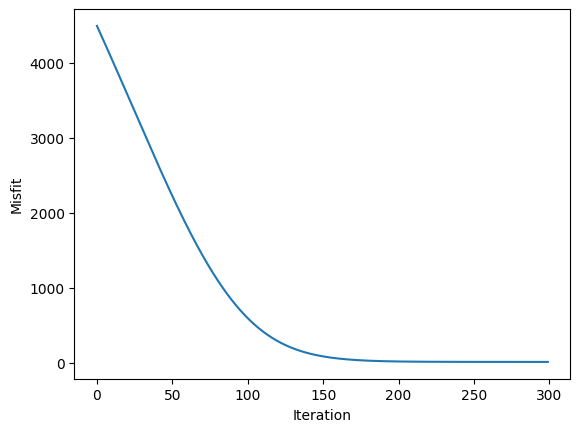

In [10]:
alpha = torch.tensor(-37.,requires_grad=True)

n_iters = 300
lr = 1e-6
L_vals = []
u_vals = []
for i in range(n_iters):
    alpha.grad = None
    A = torch.exp(alpha)
    u_pred = u_sia(z,A,H,S,dSdx,rho,g,n)    
    L = misfit(u_pred,u_obs)
    L_vals.append(L.detach())
    u_vals.append(u_pred.detach())
    L.backward()
    alpha.data -= lr*alpha.grad

plt.plot(L_vals)
plt.xlabel('Iteration')
plt.ylabel('Misfit')

And of course the resulting model predictions

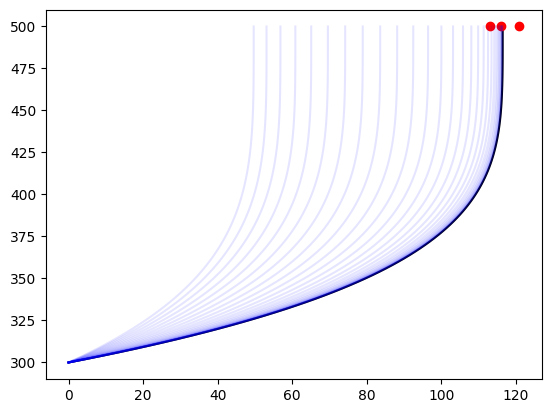

In [11]:
plt.plot(u_pred.detach(),z,'k-')
plt.plot(u_obs, S*torch.ones_like(u_obs),'ro')

for j in range(0,len(u_vals),10):
    plt.plot(u_vals[j],z,'b-',alpha=0.1)

Works good.  

# A not so minimal (but a little bit contrived) example

Pytorch can also differentiate through some significantly more complex function, including those which are oftentimes useful for classical modeling.  For example, let's look the situation in which we were trying to infer the ice hardness parameter in the case where an analytical solution is *not* available.  We will again use the SIA for this, but we will use a finite difference method to discretize coupled with a Picard iteration in order to to resolve the nonlinearity.  We can use our analytical solution to check for correctness.  

Here is a solver.  We will wrap this in a class to make the code modular.

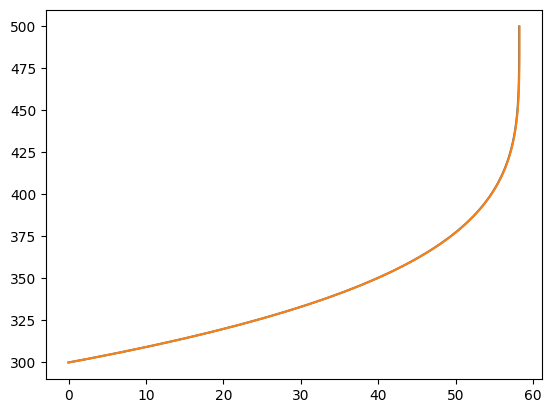

In [44]:
import torch
import numpy as np
torch.set_default_dtype(torch.float64)

class SIAFiniteDifference:
    def __init__(self,m,alpha,H,S,dSdx,rho=9.17,g=9.81,n=3,eps_reg=1e-10):
        self.m = m
        self.alpha = alpha
        self.H = H
        self.S = S
        self.dSdx = dSdx
        self.rho = rho
        self.g = g
        self.n = n
        self.eps_reg = eps_reg

        self.z = torch.linspace(S-H,S,m)
        self.dz = self.z[1] - self.z[0]

    def right_difference_operator(self):
        L = torch.zeros(self.m,self.m)
        for i in range(self.m-1):
            L[i,i] = -1/self.dz
            L[i,i+1] = 1./self.dz
        return L

    def left_difference_operator(self):
        R = torch.zeros(self.m,self.m)
        for i in range(1,self.m):
            R[i,i-1] = -1./self.dz
            R[i,i] = 1./self.dz
        return R

    def center_difference_operator(self):
        C = torch.zeros(self.m,self.m)
        for i in range(1,self.m-1):
            C[i,i-1] = -1./(2*self.dz)
            C[i,i+1] = 1./(2*self.dz)
        C[0,0] = -1/dz
        C[0,1] = 1/dz
        C[-1,-1] = 1./dz
        C[-1,-2] = -1./dz
        return C

    def apply_dirichlet(self,A,b,index,value):
        A[index] = 0
        A[index,index] = 1
        b[index] = value
        return A,b

    def apply_neumann(self,A,b,index,value):
        if index==0:
            A[index] = 0
            A[index,index] = -1./self.dz
            A[index,index+1] = 1./self.dz

        elif index==-1:
            A[index] = 0
            A[index,index-1] = -1./self.dz
            A[index,index] = 1./self.dz

        else:
            print("Only works for bottom and top")
            return A,b

        b[index] = value

        return A,b
             
    def solve(self,picard_tolerance=1e-3,maxiter=25):
        u_0 = torch.zeros(self.m)
        C = self.center_difference_operator()

        b = torch.ones(self.m)*self.rho*self.g*self.dSdx
        diff = np.inf
        iter = 0

        while diff>picard_tolerance and iter<maxiter:
            dudz = C @ u_0
            eta = 0.5*np.exp(self.alpha)**(-1./n)*(0.25*dudz**2 + self.eps_reg)**((1-n)/(2*n))
            
            G = (C * eta) @ C
            G,b = self.apply_dirichlet(G,b,0,0.0)
            G,b = self.apply_neumann(G,b,-1,0.0)
            
            u_1 = torch.linalg.solve(G,b)
            diff = torch.linalg.norm(u_1 - u_0)
            iter += 1
            u_0 = u_1       

        return u_0


H = 200
S = 500
dSdx = -0.1
rho = 917.
g = 9.81
n = 3.0

m = 100
z = torch.linspace(S-H,S,m)
dz = z[1] - z[0]

alpha = np.log(1e-16)
model = SIAFiniteDifference(m,alpha,H,S,dSdx,rho,g,n)
u = model.solve()

u_s = u_sia(model.z,np.exp(alpha),H,S,dSdx,rho,g,n)

plt.plot(u,model.z)
plt.plot(u_s,model.z)

Not perfect, but also not terrible.  Interestingly, pytorch can actually perform automatic differentiation through the Picard iteration, but this is an inefficient strategy.  Instead, we'd like to utilize an adjoint.  To derive a continuous adjoint we add the differential equation to the objective function via a Lagrange multiplier over the domain, i.e.
$$
\mathcal{J} = \mathcal{L} + \int_\Omega \left[\lambda \frac{\partial}{\partial z} \eta \frac{\partial u}{\partial z} - \lambda \rho g \frac{\partial S}{\partial x}\right] \mathrm{d}\Omega.
$$
By virtue of integration by parts, we can include boundary conditions
$$
\mathcal{J} = \mathcal{L} - \int_\Omega \left[\frac{\partial\lambda}{\partial z} \eta \frac{\partial u}{\partial z} + \lambda \rho g \frac{\partial S}{\partial x}\right] \mathrm{d}\Omega - \lambda \beta u \big|_B,
$$
where we have replaced the Dirichlet condition at the bed with the more common sliding law (a Robin boundary condition)
$$
\eta \frac{\partial u}{\partial z}\bigg|_B = -\beta u \bigg|_B.
$$
We now take the first variation (or differential, if you prefer - see [Magnus and Neudecker](https://www.janmagnus.nl/misc/mdc-ch18.pdf)) of this augmented cost function
$$
\begin{aligned}
\delta \mathcal{J} = \frac{\partial L}{\partial u} \delta u  &- \int_\Omega \bigg[\frac{\partial\delta \lambda}{\partial z} \eta \frac{\partial u}{\partial z} + \frac{\partial \lambda}{\partial z} \delta \eta \frac{\partial u}{\partial z} + \frac{\partial \lambda}{\partial z} \eta \frac{\partial \delta u}{\partial z}\\ & + \delta \lambda \rho g \frac{\partial S}{\partial x} \bigg]\mathrm{d}\Omega \\ &- \delta \lambda \beta u \bigg|_B - \lambda \beta \delta u \bigg|_B,
\end{aligned}
$$
with the variation of the viscosity
$$
\delta \eta = -\frac{\delta \alpha}{2n}\mathrm{e}^{-\frac{\alpha}{n}} \left[\frac{1}{4}\frac{\partial u}{\partial z}^2 + \epsilon \right]^{\frac{1-n}{2n}} + \frac{1}{2}\mathrm{e}^{-\frac{\alpha}{n}} \left(\frac{1 -n}{2n}\right) \left[\frac{1}{4}\frac{\partial u}{\partial z}^2 + \epsilon \right]^{\frac{1-n}{2n} - 1}\frac{1}{2}\frac{\partial u}{\partial z} \frac{\partial \delta u}{\partial z}.
$$
Collecting terms associated with the variations in $u$, $\lambda$, and $\alpha$, accounting for the integrals, and doing a bit of algebra, we can infer the following adjoint equation
$$
\frac{\partial}{\partial z} (\eta + \eta') \frac{\partial u}{\partial z} = \underbrace{-\frac{1}{\Delta z}\frac{\partial \mathcal{L}}{\partial u}}_{\text{a little bit grid-dependent}}
$$
with boundary conditions
$$
(\eta + \eta') \frac{\partial \lambda}{\partial z}\big|_S = \frac{\partial \mathcal{L}}{\partial u}\big|_S
$$
and 
$$
(\eta + \eta') \frac{\partial \lambda}{\partial z}\big|_B = \beta \lambda\big|_B - \frac{\partial \mathcal{L}}{\partial u}\big|_B.
$$
These look very similar to the SIA, but with a modification to the viscosity
$$
\eta' = \frac{1}{2}\mathrm{e}^{-\frac{\alpha}{n}} \left(\frac{1 -n}{2n}\right) \left[\frac{1}{4}\frac{\partial u}{\partial z}^2 + \epsilon \right]^{\frac{1-n}{2n} - 1}\frac{1}{2}\frac{\partial u}{\partial z} \frac{\partial \delta u}{\partial z}^2.
$$
Note that the viscosity terms don't depend on $\lambda$ and so are linear in the adjoint variable.  The gradient with respect to $\alpha$ is then given by
$$
\frac{\partial L}{\partial \alpha} = -\int_\Omega \frac{\partial u}{\partial z} \frac{1}{2n}\mathrm{e}^{-\frac{\alpha}{n}} \left[\frac{1}{4}\frac{\partial u}{\partial z}^2 + \epsilon \right]^{\frac{1-n}{2n}} \frac{\partial \lambda}{\partial z} \mathrm{d}\Omega.
$$

We can implement these modified equations using similar finite difference methods to the forward equation.  Indeed, we will use inheritance to add methods to our class for computing a solution to the adjoint equations and also to compute the gradient.


In [45]:
class SIAFiniteDifferenceAdjoint(SIAFiniteDifference):
    def __init__(self,m,alpha,H,S,dSdx,rho=9.17,g=9.81,n=3,eps_reg=1e-10):
        super().__init__(m,alpha,H,S,dSdx,rho,g,n,eps_reg)

    def solve_adjoint(self,dLdu,u,alpha):

        C = self.center_difference_operator()
   
        b = dLdu
        b[-1] = -1*b[-1]

        dudz = C @ u

        eta = 0.5*np.exp(-alpha/n)*(0.25*dudz**2 + self.eps_reg)**((1-n)/(2*n)) 
        eta_prime = 0.5*np.exp(-alpha/n)*((1-n)/(2*n))*(0.25*dudz**2 + self.eps_reg)**((1-n)/(2*n) - 1)*0.5*dudz**2
    
        G = (C * (eta + eta_prime) @ C)

        G[0] = 0
        G[-1] = 0
        G[0,0] = 1
        G[-1,-1] = (eta[-1] + eta_prime[-1])/dz
        G[-1,-2] = -(eta[-1] + eta_prime[-1])/dz
        b[1:-1] /= dz
           
        lamda = torch.linalg.solve(G,b)
      
        return lamda

    def get_grad(self,u,lamda,alpha):
    
        C = torch.zeros(m,m)
        for i in range(1,m-1):
            C[i,i+1] = 1/(2*dz)
            C[i,i-1] = -1/(2*dz)
        
        C[0,0] = -1/dz
        C[0,1] = 1/dz
        C[-1,-1] = 1./dz
        C[-1,-2] = -1./dz
    
        dudz = C @ u
        dldz = C @ lamda
    
        c = -1/(2*n)*np.exp(-alpha/n)*(0.25*dudz**2 + self.eps_reg)**((1-n)/(2*n))
    
        return dz*(dudz*c*dldz).sum()
        
model2 = SIAFiniteDifferenceAdjoint(m,alpha,H,S,dSdx,rho,g,n)
u = model2.solve()

dLdu = torch.zeros_like(u)
dLdu[-1] = (u[-1]-u_obs).mean()

lamda = model2.solve_adjoint(dLdu,u,alpha)
model2.get_grad(u,lamda,alpha)


tensor(-3471.7491)

This class has all of the necessary elements for computing gradients of arbitrary cost functions with respect to model inputs, but it cannot yet be arbitrarily composed with other functions in pytorch in a seamless way.  To do that, we need to define a custom pytorch function which subclass torch.autograd.Function.  The requirements of this class are straightforward.  First it needs a "forward" method, which accepts parameters that we wish to differentiate with respect to and produces an output.  Here that means that we will give it $\alpha$ and it will return a velocity field.  The function must be static, which is to say that it must be decorated with @staticmethod and it cannot take a model argument.  Instead, its first argument is the "context" (sometimes called the "tape") which can be used to store the variables necessary to successfully perform backpropagation.  For example, to solve the adjoint equations, we require the velocity solution itself, so after computing that we append it to the tape.  

Second, we require a backward method.  This method again accepts the context as its first argument, and as its second argument 
$$
\frac{\partial \mathcal{L}}{\partial u},
$$
the gradient of the cost with respect to the function output.  Inside this function we then solve the adjoint equations and compute the gradient, which we return.  Note that this function expects to have an output for each non-context input to forward.  If forward should not produce a gradient for one of its arguments (for example it doesn't make sense to differentiate with respect to the model object), then we can put None as the associated output gradient.  

In [48]:
class SIAModelTorch(torch.autograd.Function):
    @staticmethod
    def forward(ctx,alpha,model):
        ctx.alpha = alpha
        ctx.model = model
        model.alpha = alpha
        u = model.solve()
        ctx.u = u
        return u

    @staticmethod
    def backward(ctx, dLdu):
        model = ctx.model
        u = ctx.u
        alpha = ctx.alpha
        model.alpha = alpha

        lamda = model.solve_adjoint(dLdu,u,alpha)
        grad = model.get_grad(u,lamda,alpha)
        return grad,None

Let's test to make sure this works.  

In [49]:
alpha = torch.tensor(np.log(1e-16),requires_grad=True)
sia = SIAModelTorch()
u = sia.apply(alpha,model2)

L = (0.5*(u[-1] - u_obs)**2).mean()
L.backward()
alpha.grad

u1 = sia.apply(alpha + 1e-6,model2)
L1 = (0.5*(u1[-1]- u_obs)**2).mean()

print((L1 - L)/1e-6,alpha.grad)

tensor(-3402.5850, grad_fn=<DivBackward0>) tensor(-3471.7491)


Certainly not perfect (because we've done a bad job with our numerical discretization scheme), but good enough.  Finally, we can wrap this in a typical training loop for torch.

Text(0, 0.5, 'Misfit')

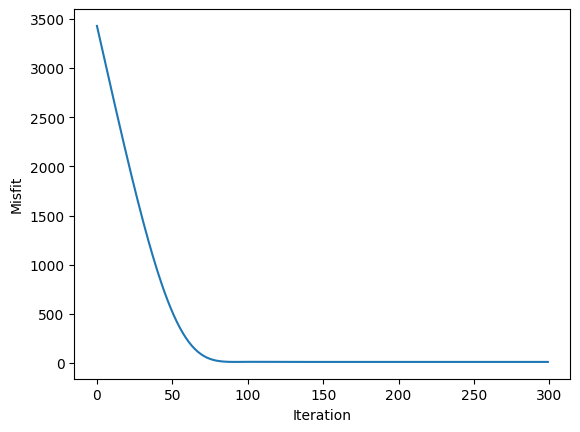

In [50]:
alpha = torch.tensor(np.log(1e-16),requires_grad=True)
sia = SIAModelTorch()

optimizer = torch.optim.Adam([alpha],lr=1e-2)

n_iters = 300

L_vals = []
u_vals = []
for i in range(n_iters):
    optimizer.zero_grad()
    u_pred = sia.apply(alpha,model2)   
    L = misfit(u_pred,u_obs)
    L_vals.append(L.detach())
    u_vals.append(u_pred.detach())
    L.backward()
    optimizer.step()

plt.plot(L_vals)
plt.xlabel('Iteration')
plt.ylabel('Misfit')

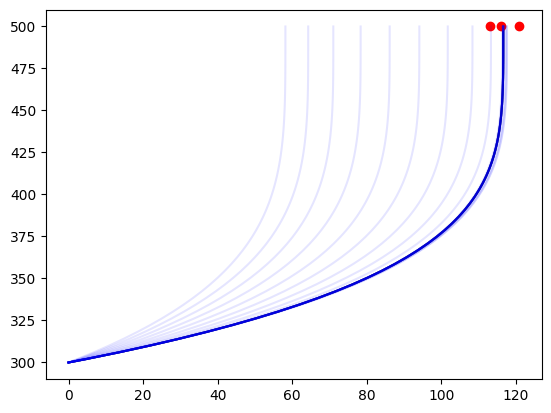

In [51]:
plt.plot(u_pred.detach(),z,'k-')
plt.plot(u_obs, S*torch.ones_like(u_obs),'ro')

for j in range(0,len(u_vals),10):
    plt.plot(u_vals[j],z,'b-',alpha=0.1)